# **Bank Term Deposit Subscription Prediction**

---

# **Stage 2**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import chi2
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling
from sklearn.feature_selection import mutual_info_regression


In [ ]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 5, 3
rcParams['lines.linewidth'] = 1.5
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
rcParams['axes.labelsize'] = 'x-small'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Read data
df = pd.read_csv('/content/drive/MyDrive/Coba Coba/final_project_audita/train.csv', delimiter=';')

In [ ]:
df.rename(columns={
    'job': 'job_type',
    'marital': 'marital_status',
    'default': 'has_default',
    'housing': 'has_housing_loan',
    'loan': 'has_personal_loan',
    'contact': 'contact_type',
    'day': 'last_contact_day',
    'month': 'last_contact_month',
    'duration': 'last_contact_duration',
    'campaign': 'num_contacts_campaign',
    'pdays': 'days_since_last_contacted',
    'previous': 'num_contacts_before_campaign',
    'poutcome': 'prev_campaign_outcome',
    'y': 'has_subs_deposit'
}, inplace=True)

#### Data Features Description
#### Numerical Features

| Feature Name| Feature Description                                                                       |
|:------------|:------------------------------------------------------------------------------------------|
| `age`       |Represents the client's age in years                                                       |
| `balance`   |Represents the client's average yearly balance in euros                                    |
| `last_contact_day`       |Represents the day of the month when the last contact with client was made                 |
| `last_contact_duration`  |Represents the duration of the last contact in seconds                                     |
| `num_contacts_campaign`  |Indicates the total number of contacts made during the current campaign and for this client, including the last contact|
| `days_since_last_contacted`     |Represents the number of days since the client was last contacted in a previous campaign   |
| `num_contacts_before_campaign`  |Indicates the total number of contacts made before the current campaign for this client    |

#### Categorical Features

| Feature Name  | Feature Description                                           |
|:--------------|:--------------------------------------------------------------|
| `job_type`         | Describes the client's type of job or occupation              |
| `marital_status`     | Indicates the client's marital status                         |
| `education`   | Specifies the client's educational level                      |
| `has_default`     | Indicates whether the client has credit in default            |
| `has_housing_loan`     | Indicates whether the client has a housing loan               |
| `has_personal_loan`        | Indicates whether the client has a personal loan              |
| `contact_type`	    | Describes the type of communication used by client            |
| `last_contact_month`       | Specifies the month of the year when the last contact occurred|
| `prev_campaign_outcome`    | Describes the outcome of the previous marketing campaign      |

#### Target Feature

| Feature Name  | Feature Description                                           |
|:--------------|:--------------------------------------------------------------|
| `has_subs_deposit`           | Specifies whether the client has subscribed to a term deposit |


# 1. Data Cleansing

## 1.1 Handle missing values

In [ ]:
# Cek NaN value
df.isna().sum()

age                             0
job_type                        0
marital_status                  0
education                       0
has_default                     0
balance                         0
has_housing_loan                0
has_personal_loan               0
contact_type                    0
last_contact_day                0
last_contact_month              0
last_contact_duration           0
num_contacts_campaign           0
days_since_last_contacted       0
num_contacts_before_campaign    0
prev_campaign_outcome           0
has_subs_deposit                0
dtype: int64

In [ ]:
#Persentase nilai unknown dalam data
df[df.columns[df.isin(['unknown']).any()]].apply(lambda x: x == 'unknown').sum() / len(df) * 100

job_type                  0.637013
education                 4.107407
contact_type             28.798301
prev_campaign_outcome    81.747805
dtype: float64

**Pertimbangan handle missing values**<br>
Dari data diatas diketahui bahwa data 'unknown' terdapat pada beberapa fitur yaitu:
- `job_type` (288 row atau 0.6% dari total row)
- `education` (1857 row atau 4.1% dari total row)
- `contact_type` (13020 row atau 28.7% dari total row)
- `prev_campaign_outcome` (36959 row atau 81.7% dari total row)
<br> Fitur yang berisi 'unknown' ini merupakan fitur kategorikal. Opsi yang dapat dipilih untuk menangani permasalahan ini adalah drop row jika total unknown data pada satu fitur tidak lebih dari 10% dari jumlah data (4521) dan imputation menggunakan modus atau nilai lain ataupun nilai konstan.

**Conclusion**<br>
Data unknown dari fitur diatas akan di isi dengan data modus karena fitur tersebut bersifat kategorik, tidak data unknown yang akan di drop dengan asumsi data tersebut adalah data unique yang akan mempengaruhi asumsi pemodelan dan kualitas data yang akan dihasilkan.

### 1.1.1 Handling `job_type` 'unknown' Values

Mengecek modus value fitur `job_type`

In [ ]:
df['job_type'].value_counts() / len(df) * 100

job_type
blue-collar      21.525735
management       20.919688
technician       16.803433
admin.           11.437482
services          9.188029
retired           5.007631
self-employed     3.492513
entrepreneur      3.289023
unemployed        2.882042
housemaid         2.742695
student           2.074716
unknown           0.637013
Name: count, dtype: float64

In [ ]:
df.groupby(['education', 'job_type']).size().groupby('education', group_keys=False).apply(lambda x: x.sort_values(ascending=False).head(2) / x.sum()).reset_index(name='percentage').sort_values(['education', 'percentage'], ascending=[True, False])

,education,job_type,percentage
0,primary,blue-collar,0.548533
1,primary,retired,0.116041
2,secondary,blue-collar,0.231489
3,secondary,technician,0.225369
4,tertiary,management,0.586497
5,tertiary,technician,0.147959
6,unknown,blue-collar,0.244480
7,unknown,management,0.130318


Modus dari fitur `job_type` yaitu 'blue-collar' jumlah datanya tidak terlalu berbeda dengan modus kedua yaitu 'management'. Kemudian ketika di cek cara lain, yaitu mengecek modus `job_type` berdasarkan `education`, terlihat bahwa beberapa `education` modus `job_type` nya hampir mendekati. Mempertimbangkan hal ini dan juga jumlah unknown yang hanya 0.6% atau 288 row dari keseluruhan data, maka baris data yang berisi value 'unknown' pada fitur `job_type` akan di drop.

In [ ]:
# drop row dengan values unknown pada 'job_type
df.drop(df[df['job_type'] == 'unknown'].index, inplace=True)

In [ ]:
df['job_type'].value_counts()

job_type
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
Name: count, dtype: int64

In [ ]:
# Mengganti values 'job_type' admin. menjadi admin
df['job_type'] = df['job_type'].replace('admin.', 'admin')

### 1.1.2 Handling `education` 'unknown' Values

In [ ]:

df['education'].value_counts() / len(df) * 100

education
secondary    51.490328
tertiary     29.521626
primary      15.137012
unknown       3.851034
Name: count, dtype: float64

In [ ]:
df.groupby(['job_type','education']).size().groupby('job_type', group_keys=False).apply(lambda x: x.sort_values(ascending=False).head(2) / x.sum()).reset_index(name='percentage').sort_values(['job_type', 'percentage'], ascending=[True, False])

,job_type,education,percentage
0,admin,secondary,0.815896
1,admin,tertiary,0.110617
2,blue-collar,secondary,0.551891
3,blue-collar,primary,0.386149
4,entrepreneur,tertiary,0.461332
5,entrepreneur,secondary,0.364492
6,housemaid,primary,0.505645
7,housemaid,secondary,0.318548
8,management,tertiary,0.824804
9,management,secondary,0.118524


Modus dari fitur `education` yaitu 'secondary' dengan jarak yang cukup jauh dengan modus kedua 'tertiary', ketika dilihat dengan cara lain yaitu modus `education` berdasarkan `job_type`, dapat dilihat bahwa setiap `education` dari `job_type` memang didominasi oleh 'secondary' dan beberapa ada yang 'tertiary'. Jarak diantara modus pertama dan modus kedua juga tidak terlalu dekat. Sehingga akan dilakukan imputation nilai unknown dari fitur `education` dengan modus dari `education` dari setiap `job_type`

In [ ]:
#Mengisi nilai unknown dari 'education' dengan modus 'education' dari setiap 'job_type'
def fill_unknown_education(df):
    mode_dict = df[df['education'] != 'unknown'].groupby('job_type')['education'].apply(lambda x: x.mode().iloc[0]).to_dict()
    df['education'] = df.apply(lambda row: mode_dict[row['job_type']] if row['education'] == 'unknown' else row['education'], axis=1)
    return df

df = fill_unknown_education(df)

### 1.1.3 Handling `contact_type` 'unknown' Values

In [ ]:

df['contact_type'].value_counts() / len(df) * 100

contact_type
cellular     64.897714
unknown      28.735837
telephone     6.366449
Name: count, dtype: float64

Modus dari fitur `contact_type` yaitu 'cellular' dengan jarak terhadap modus kedua tidak berdekatan sehingga nilai unknown pada fitur `contact_type` akan dilakukan imputation dengan nilai modus yaitu 'cellular'

In [ ]:
# Mengisi nilai inknown dengan modus dari 'contact_type'
df['contact_type'].replace(['unknown'],df['contact_type'].mode(),inplace = True)

In [ ]:
df['contact_type'].value_counts()

contact_type
cellular     42063
telephone     2860
Name: count, dtype: int64

### 1.1.4 Handling `prev_campaign_outcome` 'unknown' Values

In [ ]:
df['prev_campaign_outcome'].value_counts() / len(df) * 100

prev_campaign_outcome
unknown    81.704249
failure    10.865258
other       4.091445
success     3.339047
Name: count, dtype: float64

Nilai 'unknown' pada fitur `prev_campaign_outcome` sangat mendominasi hingga 81.7% dari total kesluruhan row data. Sehingga jika mengisinya langsung dengan modus yaitu failure merupakan keputusan yang kurang bijak. Untuk mengatasi hal ini, sebelumnya perlu dicek apakah ada pola tertentu yang berhubungan dengan kolom lain dengan nilai 'unknown' pada fitur `prev_campaign_outcome`

In [ ]:
df[df['prev_campaign_outcome'] == 'unknown'].shape

(36704, 17)

In [ ]:
df[(df['prev_campaign_outcome'] == 'unknown') &
   (df['days_since_last_contacted'] == -1) &
   (df['num_contacts_before_campaign'] == 0)].shape

(36699, 17)

In [ ]:
df[(df['prev_campaign_outcome'] == 'unknown') &
   (df['days_since_last_contacted'] == -1) &
   (df['num_contacts_before_campaign'] == 0)]

,age,job_type,marital_status,education,has_default,balance,has_housing_loan,has_personal_loan,contact_type,last_contact_day,last_contact_month,last_contact_duration,num_contacts_campaign,days_since_last_contacted,num_contacts_before_campaign,prev_campaign_outcome,has_subs_deposit
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,cellular,5,may,139,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45203,23,student,single,tertiary,no,113,no,no,cellular,17,nov,266,1,-1,0,unknown,yes
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,-1,0,unknown,yes
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes


Nilai 'unknown' pada fitur `prev_campaign_outcome` ada 36959 row data. Ketika dilihat dengan fitur lain pada data, fitur `prev_campaign_outcome` memiliki hubungan terutama dengan fitur `days_since_last_contacted` dan `num_contacts_before_campaign`. Dari 36704 row data fitur `prev_campaign_outcome` yang bernilai 'unknown', 36699 row data fitur `days_since_last_contacted` nya bernilai -1 dan `num_contacts_before_campaign` nya bernilai 0. fitur `days_since_last_contacted` = -1 berarti nasabah belum pernah dikontak sebelumnya dan fitur `num_contacts_before_campaign` = 0 berarti nasabah tidak dikontak pada sebelum current campaign. Berdasarkan hal ini dapat diasumsikan bahwa sebagian besar nilai 'unknown' pada fitur `prev_campaign_outcome` selaras dengan kondisi dimana nasabah belum dikontak oleh bank. Oleh karena itu nilai 'unknown' yang memenuhi kriteria ini akan diganti dengan nilai lain yaitu 'not_contacted' yang lebih bisa diinterpretasikan maksudnya.

In [ ]:

# Mengganti values 'prev_campaign_outcome' unknown menjadi not_contacted
df.loc[(df['days_since_last_contacted'] == -1) & (df['num_contacts_before_campaign'] == 0), 'prev_campaign_outcome'] = 'not_contacted'

In [ ]:
df['prev_campaign_outcome'].value_counts() / len(df) * 100

prev_campaign_outcome
not_contacted    81.693119
failure          10.865258
other             4.091445
success           3.339047
unknown           0.011130
Name: count, dtype: float64

#### Cek hasil 'unknown' values handling

In [ ]:
(df == 'unknown').sum()

age                             0
job_type                        0
marital_status                  0
education                       0
has_default                     0
balance                         0
has_housing_loan                0
has_personal_loan               0
contact_type                    0
last_contact_day                0
last_contact_month              0
last_contact_duration           0
num_contacts_campaign           0
days_since_last_contacted       0
num_contacts_before_campaign    0
prev_campaign_outcome           5
has_subs_deposit                0
dtype: int64

#### Mengganti nilai di kolom days_since_last_contacted dari -1 menjadi 0

In [ ]:
df['days_since_last_contacted'] = df['days_since_last_contacted'].replace(-1, 0)

## 1.2 Handle duplicated data

In [ ]:
df.duplicated().sum()

0

**Tidak ada data duplikat dalam data**<br/>
Kode diatas mengidentifikasi baris yang identik (keseluruhan nilai di semua kolom) dengan baris lainnya dalam data. Karena hasilnya 0, maka keseluruhan nilai di semua kolom di setiap baris adalah unik.

## 1.3 Handling Outliers

In [ ]:
nums = df.select_dtypes(include=['number']).columns
cats = df.select_dtypes(include=['object']).columns

### 1.3.2 FIltering Outlier

Tidak melakukan filtering outlier, terdapat angka minus sehingga ketika melakukan outlier dikhawatirkan akan merubah nilai pada data.

# 2. Feature Engineering
## 2.1 Feature Extraction
### 2.1.1 Feature Extraction : `age`
Fitur `age` akan di ekstraksi dengan rincian:
- Usia < 12 tahun = Child (kanak-kanak)
- Usia 12-25 tahun = Teenager (remaja)
- Usia 26-45 tahun = Adult (dewasa)
- Usia > 45 tahun = Elderly (lansia)

In [ ]:
#Membuat fungsi untuk klsifikasi umur
def categorize_age(umur):
    if umur <= 11:
        result = 'child'
    elif umur <= 25:
        result = 'teenager'
    elif umur <= 45:
        result = 'adult'
    else:
        result = 'elderly'
    return result

df['age_category'] = df['age'].apply(categorize_age)
df.sample(1)

,age,job_type,marital_status,education,has_default,balance,has_housing_loan,has_personal_loan,contact_type,last_contact_day,last_contact_month,last_contact_duration,num_contacts_campaign,days_since_last_contacted,num_contacts_before_campaign,prev_campaign_outcome,has_subs_deposit,age_category
8907,47,blue-collar,married,secondary,no,273,yes,no,cellular,4,jun,163,1,0,0,not_contacted,no,elderly


### 2.1.2 Feature Extraction : `balance`

In [ ]:
df['balance'].describe().loc[['min', '25%', '50%', '75%', 'max']]

min     -8019.0
25%        72.0
50%       447.0
75%      1421.0
max    102127.0
Name: balance, dtype: float64

Berdasarkan data diatas, fitur `balance` akan di klasifikasikan dengan rincian sebagai berikut :
- Negative Balance: balance < 0
- Null Balance: balance = 0
- Low Balance: balance > 0 hingga Q2
- Medium Balance: balance > Q2 hingga Q3
- High Balance: balance > Q3

In [ ]:
#Membuat fungsi untuk klsifikasi balance
Q2 = df['balance'].quantile(0.5)
Q3 = df['balance'].quantile(0.75)
def categorize_balance(value):
    if value < 0:
        return 'negative'
    elif value == 0:
        return 'zero'
    elif value <= Q2:
        return 'low'
    elif value <= Q3:
        return 'medium'
    else:
        return 'high'

df['balance_category'] = df['balance'].apply(categorize_balance)
df.sample(1)

,age,job_type,marital_status,education,has_default,balance,has_housing_loan,has_personal_loan,contact_type,last_contact_day,last_contact_month,last_contact_duration,num_contacts_campaign,days_since_last_contacted,num_contacts_before_campaign,prev_campaign_outcome,has_subs_deposit,age_category,balance_category
1270,48,blue-collar,married,primary,no,4,yes,no,cellular,8,may,198,1,0,0,not_contacted,no,elderly,low


### 2.1.3 Feature Extraction : `last_contact_day`
fitur `last_contact_day` akan di ekstrak dengan rincian sebagai berikut :
- Day 1-7 : week_1
- Day 8-14 : week_2
- Day 15-21 : week_3
- Day 22-31 : week_4

In [ ]:
# fungsi untuk klasifikasi 'last_contact_day'
def categorize_day(x):
    day = x
    if day <= 7:
        result = 'week_1'
    elif day <= 14:
        result = 'week_2'
    elif day <= 21:
        result = 'week_3'
    else:
        result = 'week_4'
    return result

df['day_category'] = df['last_contact_day'].apply (lambda x: categorize_day(x))
df.sample(1)

,age,job_type,marital_status,education,has_default,balance,has_housing_loan,has_personal_loan,contact_type,last_contact_day,last_contact_month,last_contact_duration,num_contacts_campaign,days_since_last_contacted,num_contacts_before_campaign,prev_campaign_outcome,has_subs_deposit,age_category,balance_category,day_category
14794,47,technician,single,secondary,no,1710,no,yes,cellular,16,jul,525,2,0,0,not_contacted,no,elderly,high,week_3


### 2.1.4 Feature Extraction : `last_contact_month`
fitur `last_contact_month` akan di ekstrak berdasarkan kuartal dalam satu tahun dengan rincian :
- Month jan-mar : Q1
- Month apr-jun : Q2
- Month jul-sep : Q3
- Month oct-dec : Q4

In [ ]:
# fungsi untuk klsifikasi 'last_contact_month'
def categorize_month(x):
    month = x
    q1 = ['jan', 'feb', 'mar']
    q2 = ['apr', 'may', 'jun']
    q3 = ['jul', 'aug', 'sep']
    q4 = ['oct', 'nov', 'dec']

    if month in q1:
        result = 'Q1'
    elif month in q2:
        result = 'Q2'
    elif month in q3:
        result = 'Q3'
    else:
        result = 'Q4'
    return result

df['quarter'] = df['last_contact_month'].apply(lambda x: categorize_month(x))
df.sample(1)

,age,job_type,marital_status,education,has_default,balance,has_housing_loan,has_personal_loan,contact_type,last_contact_day,...,last_contact_duration,num_contacts_campaign,days_since_last_contacted,num_contacts_before_campaign,prev_campaign_outcome,has_subs_deposit,age_category,balance_category,day_category,quarter
5489,30,technician,married,secondary,no,590,yes,no,cellular,23,...,242,3,0,0,not_contacted,no,adult,medium,week_4,Q2


### 2.1.5 Feature Extraction : `last_contact_duration`

In [ ]:
df['last_contact_duration'].describe().loc[['min', '25%', '50%', '75%', 'max']]

min       0.0
25%     103.0
50%     180.0
75%     319.0
max    4918.0
Name: last_contact_duration, dtype: float64

Berdasarkan data diatas, fitur `last_contact_duration` akan di ekstrak dengan rincian sebagai berikut :
- no contact (none) : duration = 0
- short : duration > 0 hingga Q2
- medium : duration > Q2 hingga Q3
- long : duration > Q3

In [ ]:
# fungsi untuk klsifikasi 'last_contact_duration'
Q2 = df['last_contact_duration'].quantile(0.5)
Q3 = df['last_contact_duration'].quantile(0.75)
def categorize_duration(x):
    durasi = x
    if durasi <= 0:
        result = 'fail'
    elif durasi <= Q2:
        result = 'short'
    elif durasi <= Q3:
        result = 'medium'
    else:
        result = 'long'
    return result

df['last_contact_duration_category'] = df['last_contact_duration'].apply (lambda x: categorize_duration(x))
df.sample(1)

,age,job_type,marital_status,education,has_default,balance,has_housing_loan,has_personal_loan,contact_type,last_contact_day,...,num_contacts_campaign,days_since_last_contacted,num_contacts_before_campaign,prev_campaign_outcome,has_subs_deposit,age_category,balance_category,day_category,quarter,last_contact_duration_category
26207,30,management,married,tertiary,no,196,no,no,cellular,20,...,1,101,4,other,no,adult,low,week_3,Q4,short


### 2.1.6 Feature Extraction : `num_contacts_campaign`

In [ ]:
print(df['num_contacts_campaign'].describe().loc[['min', '25%', '50%', '75%', 'max']])
print('90%    ',df['num_contacts_campaign'].quantile(0.90))

min     1.0
25%     1.0
50%     2.0
75%     3.0
max    63.0
Name: num_contacts_campaign, dtype: float64
90%     5.0


Berdasarkan data diatas, fitur `num_contacts_campaign` akan di ekstrak dengan rincian sebagai berikut :
- few : num_contacts_campaign min hingga Q2
- moderate : num_contacts_campaign > Q2 hingga percentile 90
- frequent : num_contacts_campaign > percentile 90

In [ ]:
#Fungsi klasifikasi 'num_contacts_campaign'
Q2 = df['num_contacts_campaign'].quantile(0.5)
P90 = df['num_contacts_campaign'].quantile(0.90)
def categorize_num_cont_camp(x):
    camp = x
    if camp <= Q2:
        result = 'few'
    elif camp <= P90:
        result = 'moderate'
    else:
        result = 'frequent'
    return result

df['num_contacts_campaign_category'] = df['num_contacts_campaign'].apply(lambda x: categorize_num_cont_camp(x))
df.sample(1)

,age,job_type,marital_status,education,has_default,balance,has_housing_loan,has_personal_loan,contact_type,last_contact_day,...,days_since_last_contacted,num_contacts_before_campaign,prev_campaign_outcome,has_subs_deposit,age_category,balance_category,day_category,quarter,last_contact_duration_category,num_contacts_campaign_category
24854,46,admin,divorced,secondary,no,7378,no,no,cellular,18,...,0,0,not_contacted,no,elderly,high,week_3,Q4,long,few


### 2.1.7 Feature Extraction : `days_since_last_contacted`
fitur `days_since_last_contacted` akan di ekstrak dengan rincian sebagai berikut :
- no_contact : days_since_last_contacted = -1
- in_week : days_since_last_contacted <=7
- weeks : days_since_last_contacted <=21
- in_month : days_since_last_contacted <=31
- months : days_since_last_contacted > 31 hingga 365
- in_year : days_since_last_contacted > 365 hingga 730
- years : days_since_last_contacted > 730

In [ ]:
# fungsi untuk mencari klasifikasi 'days_since_last_contacted'
def categorize_days_since_last_contacted(pdays):
    if pdays == -1:
        return 'no_contact'
    elif pdays <= 7:
        return 'in_week'
    elif pdays <= 21:
        return 'weeks'
    elif pdays <= 31:
        return 'in_month'
    elif 31 < pdays <= 365:
        return 'months'
    elif 365 < pdays <= 730:
        return 'in_year'
    else:
        return 'years'

df['days_since_last_contacted_category'] = df['days_since_last_contacted'].apply(lambda x: categorize_days_since_last_contacted(x))
df.sample(1)

,age,job_type,marital_status,education,has_default,balance,has_housing_loan,has_personal_loan,contact_type,last_contact_day,...,num_contacts_before_campaign,prev_campaign_outcome,has_subs_deposit,age_category,balance_category,day_category,quarter,last_contact_duration_category,num_contacts_campaign_category,days_since_last_contacted_category
41860,40,technician,married,secondary,no,2266,no,no,cellular,16,...,5,failure,yes,adult,high,week_3,Q4,long,few,months


### 2.1.8 Feature Extraction `num_contacts_before_campaign`

In [ ]:
print(df['num_contacts_before_campaign'].describe().loc[['min', '25%', '50%', '75%', 'max']])
print('90%    ',df['num_contacts_before_campaign'].quantile(0.90))
print('99%    ',df['num_contacts_before_campaign'].quantile(0.99))

min      0.0
25%      0.0
50%      0.0
75%      0.0
max    275.0
Name: num_contacts_before_campaign, dtype: float64
90%     2.0
99%     9.0


Pada tahap ini data unique dari fitur 'previous' akan di ekstrak untuk mendapatkan/mengembangkan lebih banyak insight dengan pertimbangan sebagai bahwa fitur previous berisi data yang sama dengan fitur campaign, maka klasifikasinya dibuat berdasarkan fitur campaign:
- Previous 0 = no_contact
- Previous 1-2 = few (> min hingga percentile 90)
- Previous 3-9 = medium (> percentile 90 hingga percentile 99)   
- Previous > 9 = frequent (> percentile 95)

In [ ]:
#Membuat fungsi untuk mencari klsifikasi num_contacts_before_campaign
P90 = df['num_contacts_before_campaign'].quantile(0.90)
P99 = df['num_contacts_before_campaign'].quantile(0.99)
def prev_num(x):
    prev = x
    if prev == 0:
        result = 'no_contact'
    elif prev <= P90:
        result = 'few'
    elif prev <= P99:
        result = 'medium'
    else:
        result = 'frequent'
    return result

df['num_contacts_before_campaign_category'] = df['num_contacts_before_campaign'].apply (lambda x: prev_num(x))
df.sample(1)

,age,job_type,marital_status,education,has_default,balance,has_housing_loan,has_personal_loan,contact_type,last_contact_day,...,prev_campaign_outcome,has_subs_deposit,age_category,balance_category,day_category,quarter,last_contact_duration_category,num_contacts_campaign_category,days_since_last_contacted_category,num_contacts_before_campaign_category
7808,51,retired,married,primary,no,752,yes,no,cellular,30,...,not_contacted,no,elderly,medium,week_4,Q2,medium,few,in_week,no_contact


In [ ]:
df['prev_campaign_outcome'].value_counts()

prev_campaign_outcome
not_contacted    36699
failure           4881
other             1838
success           1500
unknown              5
Name: count, dtype: int64

In [ ]:
#Kolom Reorder
df = df[df.columns[[0,17,1,2,3,4,5,18,6,7,8,9,19,10,20,11,21,12,22,13,23,14,24,15,16,]]]
df.sample(2)

,age,age_category,job_type,marital_status,education,has_default,balance,balance_category,has_housing_loan,has_personal_loan,...,last_contact_duration,last_contact_duration_category,num_contacts_campaign,num_contacts_campaign_category,days_since_last_contacted,days_since_last_contacted_category,num_contacts_before_campaign,num_contacts_before_campaign_category,prev_campaign_outcome,has_subs_deposit
6703,46,elderly,admin,married,secondary,no,-363,negative,yes,yes,...,236,medium,1,few,0,in_week,0,no_contact,not_contacted,no
26490,45,adult,self-employed,married,secondary,no,7,low,no,no,...,691,long,1,few,0,in_week,0,no_contact,not_contacted,yes


## 2.2 Feature Encoding & Selection

### 2.2.1 Feature Encoding
Feature encoding dilakukan untuk kepentingan analisa feature selection untuk melihat korelasi fitur terhadap target, dan nantinya akan digunakan untuk pemodelan machine learning.

#### 2.2.1.1 One Hot Encoding

In [ ]:
df_encoded = pd.get_dummies(df[['job_type', 'marital_status', 'contact_type', 'prev_campaign_outcome']])
df_encoded = df_encoded.astype(int)
df_encoded.sample(2)

,job_type_admin,job_type_blue-collar,job_type_entrepreneur,job_type_housemaid,job_type_management,job_type_retired,job_type_self-employed,job_type_services,job_type_student,job_type_technician,...,marital_status_divorced,marital_status_married,marital_status_single,contact_type_cellular,contact_type_telephone,prev_campaign_outcome_failure,prev_campaign_outcome_not_contacted,prev_campaign_outcome_other,prev_campaign_outcome_success,prev_campaign_outcome_unknown
42485,0,0,0,0,0,0,0,0,0,1,...,0,1,0,1,0,1,0,0,0,0
29170,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,0


#### 2.2.1.2 Label Encoding

In [ ]:
#Label Encoding
has_cols = ['has_subs_deposit', 'has_default', 'has_housing_loan', 'has_personal_loan']
for col in has_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

In [ ]:
#Label Encoding
df['job_type'] = df['job_type'].map({'admin': 0, 'blue-collar': 1, 'entrepreneur': 2, 'housemaid': 3, 'management': 4, 'retired': 5, 'self-employed': 6, 'services': 7, 'student': 8, 'technician': 9, 'unemployed': 10})
df['marital_status'] = df['marital_status'].map({'single': 0, 'married': 1, 'divorced': 2})
df['contact_type'] = df['contact_type'].map({'cellular': 0, 'telephone': 1})
df['age_category'] = df['age_category'].map({'teenager': 0, 'adult': 1, 'elderly': 2})
df['education'] = df['education'].map({'primary': 0, 'secondary': 1, 'tertiary': 2})
df['balance_category'] = df['balance_category'].map({'negative': 0, 'zero': 1, 'low': 2, 'medium': 3, 'high': 4})
df['day_category'] = df['day_category'].map({'week_1': 0, 'week_2': 1, 'week_3': 2, 'week_4': 3})
df['last_contact_month'] = df['last_contact_month'].map({'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4, 'jun': 5, 'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov':10, 'dec':11 })
df['quarter'] = df['quarter'].map({'Q1': 0, 'Q2': 1, 'Q3': 2, 'Q4':3})
df['last_contact_duration_category'] = df['last_contact_duration_category'].map({'fail': 0, 'short': 1, 'medium': 2, 'long': 3})
df['num_contacts_campaign_category'] = df['num_contacts_campaign_category'].map({'few': 0, 'moderate': 1, 'frequent': 2})
df['days_since_last_contacted_category'] = df['days_since_last_contacted_category'].map({'no_contact': 0, 'in_week': 1, 'weeks': 2, 'in_month': 3, 'months': 4, 'in_year': 5, 'years':6})
df['num_contacts_before_campaign_category'] = df['num_contacts_before_campaign_category'].map({'no_contact': 0, 'few': 1, 'medium': 2, 'frequent': 3})
df['prev_campaign_outcome'] = df['prev_campaign_outcome'].map({'not_contacted':0, 'failure': 1, 'success': 2, 'other':3, 'unknown':4})

In [ ]:
df_combined = pd.concat([df, df_encoded], axis=1)

In [ ]:
df = df_combined

In [ ]:
df = df[df.columns[[0,1,2,25,26,27,28,29,30,31,32,33,34,35,3,36,37,38,4,5,6,7,8,9,10,39,40,11,12,13,14,15,16,17,18,19,20,21,22,23,41,42,43,44,45,24]]]
df.sample(2)

,age,age_category,job_type,job_type_admin,job_type_blue-collar,job_type_entrepreneur,job_type_housemaid,job_type_management,job_type_retired,job_type_self-employed,...,days_since_last_contacted_category,num_contacts_before_campaign,num_contacts_before_campaign_category,prev_campaign_outcome,prev_campaign_outcome_failure,prev_campaign_outcome_not_contacted,prev_campaign_outcome_other,prev_campaign_outcome_success,prev_campaign_outcome_unknown,has_subs_deposit
31359,30,1,4,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1
1475,42,1,1,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [ ]:
dfcopy=df.copy()

### 2.2.2 Feature Selection

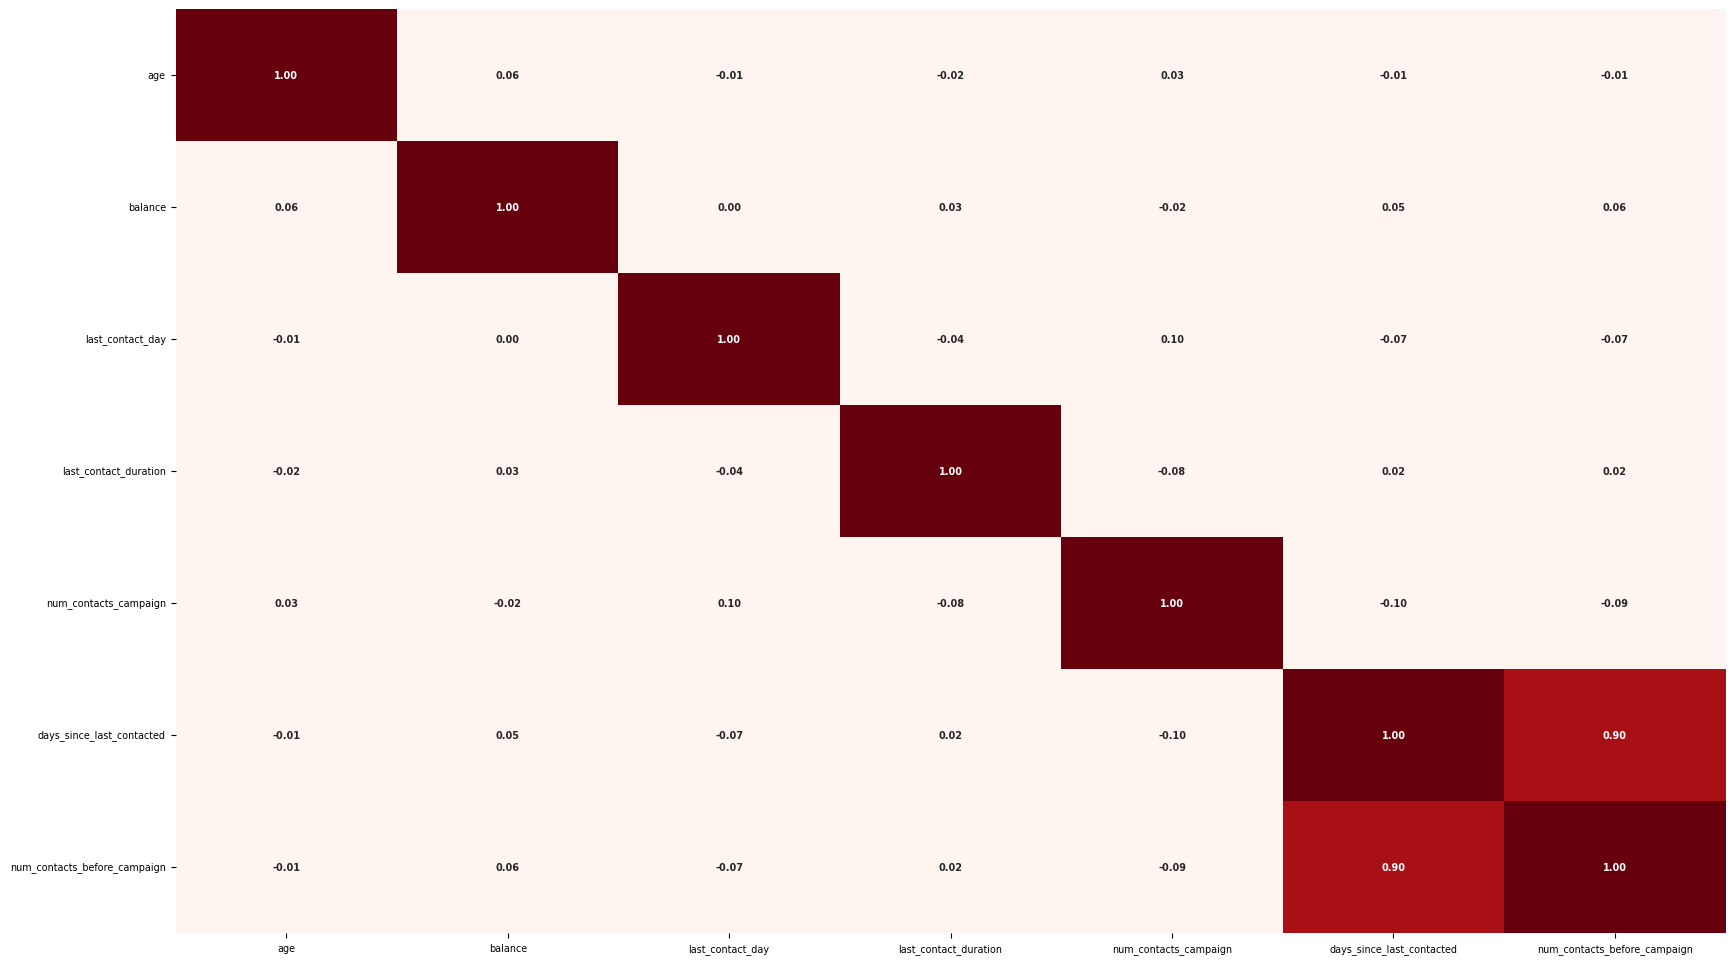

In [ ]:
#Kendall tau correlation (numerik to categoric)
corr = df[nums].corr('kendall')
plt.figure(figsize=(20, 12))
sns.heatmap(corr, annot=True, cmap='Reds', fmt='.2f',annot_kws={"size": 7, 'weight': 'bold'}, cbar=False, vmin=0.3)
plt.show()

In [ ]:
#Analisa korelasi chi2 (categoric to categoric)
X = df[['age_category', 'job_type', 'marital_status', 'education', 'has_default', 'balance_category', 'has_housing_loan', 'has_personal_loan',
        'contact_type', 'day_category', 'last_contact_month', 'quarter', 'last_contact_duration_category', 'num_contacts_campaign_category',
        'days_since_last_contacted_category', 'num_contacts_before_campaign_category', 'prev_campaign_outcome']]
y = df['has_subs_deposit']

chi_scores = chi2(X,y)

print(X.columns)
chi_scores

Index(['age_category', 'job_type', 'marital_status', 'education',
       'has_default', 'balance_category', 'has_housing_loan',
       'has_personal_loan', 'contact_type', 'day_category',
       'last_contact_month', 'quarter', 'last_contact_duration_category',
       'num_contacts_campaign_category', 'days_since_last_contacted_category',
       'num_contacts_before_campaign_category', 'prev_campaign_outcome'],
      dtype='object')


(array([4.86569855e-01, 1.85057513e+02, 4.09971473e+01, 8.34604356e+01,
        2.21233171e+01, 2.42840624e+02, 3.88432135e+02, 1.78066378e+02,
        8.61314652e+00, 1.20354703e+01, 1.87181779e+01, 4.78966324e+00,
        1.88883869e+03, 2.40563424e+02, 1.15721280e+03, 1.65881311e+03,
        2.62371816e+03]),
 array([4.85461416e-001, 3.81278662e-042, 1.52451578e-010, 6.50040155e-020,
        2.55685175e-006, 9.44794882e-055, 1.81637347e-086, 1.28121167e-040,
        3.33745244e-003, 5.21976633e-004, 1.51531040e-005, 2.86310237e-002,
        0.00000000e+000, 2.96383799e-054, 1.21420702e-253, 0.00000000e+000,
        0.00000000e+000]))

In [ ]:
X = df.copy()
y = X.pop('has_subs_deposit')

# Feature yang akan di diskret
discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  #Menampilkan score MI

last_contact_duration                    0.093601
prev_campaign_outcome                    0.031804
last_contact_month                       0.021649
num_contacts_before_campaign_category    0.012876
last_contact_day                         0.011893
job_type_blue-collar                     0.007677
quarter                                  0.005614
job_type_retired                         0.002734
job_type_unemployed                      0.001765
job_type_technician                      0.001082
prev_campaign_outcome_other              0.000513
contact_type_telephone                   0.000124
job_type_management                      0.000084
job_type_housemaid                       0.000000
marital_status_single                    0.000000
Name: MI Scores, dtype: float64

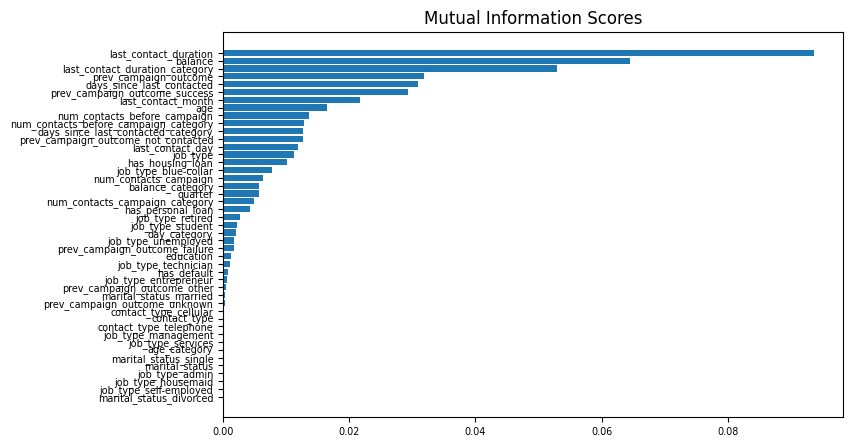

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [ ]:
# membuang feature redundant

import numpy as np
correlation_matrix = df.corr('kendall')
# Menggunakan 'bool' sebagai pengganti 'np.bool'
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_correlation_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]

# Menampilkan fitur yang memiliki korelasi tinggi
print("Fitur dengan korelasi tinggi:", high_correlation_features)


Fitur dengan korelasi tinggi: ['balance_category', 'contact_type_telephone', 'day_category', 'quarter', 'last_contact_duration_category', 'num_contacts_campaign_category', 'days_since_last_contacted_category', 'num_contacts_before_campaign', 'num_contacts_before_campaign_category', 'prev_campaign_outcome', 'prev_campaign_outcome_failure']


In [ ]:
df = df.drop(['balance_category','day_category','quarter','contact_type' ,'last_contact_duration_category','marital_status','contact_type',
              'num_contacts_campaign_category', 'days_since_last_contacted_category','num_contacts_before_campaign_category',
              'prev_campaign_outcome','last_contact_month','last_contact_day'], axis = 1)

## 2.3 Feature transformation (Normalisasi/Standarisasi)

In [ ]:
# #Split data train test
X = df.drop(['has_subs_deposit'], axis=1)
y = df['has_subs_deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)


In [ ]:
from sklearn.preprocessing import RobustScaler

# Inisialisasi RobustScaler
scaler = RobustScaler()

# Terapkan skala pada data pelatihan
X_train= scaler.fit_transform(X_train)

# Terapkan skala yang sama pada data pengujian
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(29948, 33)
(14975, 33)


## 2.4 Handle class imbalance
Letaknya dimana (step ini setelah step apa) masih not sure

In [ ]:
df['has_subs_deposit'].value_counts() / len(df) * 100

has_subs_deposit
0    88.302206
1    11.697794
Name: count, dtype: float64

Derajat ketimpangan fitur target termasuk dalam kategori moderate dengan nilai yes atau 1 yaitu 11% sementara nilai no atau 0 yaitu 88%. Class imbalance ini nantinya akan mempengaruhi hasil model Machine Learning. Oleh karena itu, untuk mengatasi permasalahan ini, akan dilakukan oversampling menggunakan SMOTE (Synthetic Minority Over-sampling Technique)

In [ ]:

from collections import Counter
print("Distribusi kelas sebelum SMOTE Borderline (train):", Counter(y_train))

Distribusi kelas sebelum SMOTE Borderline (train): Counter({0: 26446, 1: 3502})


In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
smote_borderline = BorderlineSMOTE(random_state=42)
X_resampled, y_resampled = smote_borderline.fit_resample(X_train, y_train)
print("Distribusi kelas setelah SMOTE Borderline (train):", Counter(y_resampled))

Distribusi kelas setelah SMOTE Borderline (train): Counter({0: 26446, 1: 26446})


## Stage 3

Melakukan modeling :<br>


*   Desicion Tree
*   Random Forest
*   Logistic Regression
*   AdaboostClassifie
*   XGBClassifier






In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  AdaBoostClassifier,RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression




from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 5, 3
rcParams['lines.linewidth'] = 1.5
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
rcParams['axes.labelsize'] = 'x-small'

In [ ]:
def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_resampled)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_resampled)

    print("Accuracy (Train Set): %.2f" % accuracy_score(y_resampled, y_pred_train))
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Train Set): %.2f" % precision_score(y_resampled, y_pred_train))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Train Set): %.2f" % recall_score(y_resampled, y_pred_train))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Train Set): %.2f" % f1_score(y_resampled, y_pred_train))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_resampled, y_pred_proba_train[:, 1]))

    #cross valudation
    scoring = make_scorer(roc_auc_score)
    score = cross_validate(model, X, y, cv=5, scoring= scoring, return_train_score=True)
    print('roc_auc (crossval train): '+ str(score['train_score'].mean()))
    print('roc_auc (crossval test): '+ str(score['test_score'].mean()))

In [ ]:
def c_matrix_plot(y_test, y_pred):

    c_matrix = confusion_matrix(y_test, y_pred)
    names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    counts = ['{0:0.0f}'.format(value) for value in c_matrix.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    ax = sns.heatmap(c_matrix, annot = labels, fmt = '', cmap = 'mako')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['Not Subs', 'Subs'])
    ax.yaxis.set_ticklabels(['Not Subs', 'Subs'])
    plt.show()

In [ ]:
%matplotlib


models = {
    "DT"         : DecisionTreeClassifier(random_state = 42),
    "RF"         : RandomForestClassifier(random_state = 42),
    "XGB"        : XGBClassifier(random_state = 42),
    "ADB"        : AdaBoostClassifier(random_state = 42),
    "Logistic"   : LogisticRegression(random_state = 42)



}

for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    print("Evaluate model: {}".format(model_name))
    print(eval_classification(model), "\n")

Using matplotlib backend: <object object at 0x7cb8710e36c0>
Evaluate model: DT
Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.85
Precision (Train Set): 1.00
Precision (Test Set): 0.37
Recall (Train Set): 1.00
Recall (Test Set): 0.44
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.40
roc_auc (test-proba): 0.67
roc_auc (train-proba): 1.00
roc_auc (crossval train): 1.0
roc_auc (crossval test): 0.6301367899845507
None 

Evaluate model: RF
Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.89
Precision (Train Set): 1.00
Precision (Test Set): 0.51
Recall (Train Set): 1.00
Recall (Test Set): 0.46
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.48
roc_auc (test-proba): 0.88
roc_auc (train-proba): 1.00
roc_auc (crossval train): 0.9999286393910563
roc_auc (crossval test): 0.6181934903506605
None 

Evaluate model: XGB
Accuracy (Train Set): 0.96
Accuracy (Test Set): 0.88
Precision (Train Set): 0.96
Precision (Test Set): 0.51
Recall (Train Set): 0.95
Recall (Test Set): 0.50
F1-Score (Train Se

#### Hyperparameter LogisticRegesssion

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.0001, 0.05, 100)]
hyperparameters = dict(penalty=penalty, C=C)

logreg = LogisticRegression()
rs = RandomizedSearchCV(logreg, hyperparameters, scoring='roc_auc', random_state=1, cv=5, n_iter=100)
rs.fit(X_train, y_train)
eval_classification(rs)

Accuracy (Train Set): 0.59
Accuracy (Test Set): 0.90
Precision (Train Set): 0.91
Precision (Test Set): 0.65
Recall (Train Set): 0.21
Recall (Test Set): 0.26
F1-Score (Train Set): 0.34
F1-Score (Test Set): 0.37
roc_auc (test-proba): 0.88
roc_auc (train-proba): 0.90
roc_auc (crossval train): 0.5851750500254167
roc_auc (crossval test): 0.5723099888197802


#### Hyperparameter XGBoostClassifier

In [ ]:
# model xgb

xg = XGBClassifier(random_state=42)
xg.fit(X_resampled, y_resampled)
eval_classification(xg)

Accuracy (Train Set): 0.96
Accuracy (Test Set): 0.88
Precision (Train Set): 0.96
Precision (Test Set): 0.51
Recall (Train Set): 0.95
Recall (Test Set): 0.50
F1-Score (Train Set): 0.96
F1-Score (Test Set): 0.50
roc_auc (test-proba): 0.89
roc_auc (train-proba): 0.99
roc_auc (crossval train): 0.7871701413732317
roc_auc (crossval test): 0.6246036286057014


In [ ]:
#Hyperparameter tuning XGB
# List of hyperparameter
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }


# Init model
xgb = XGBClassifier(random_state=42)
model_xgb = RandomizedSearchCV(xgb, hyperparameters, cv=5, scoring= make_scorer(roc_auc_score))
model_xgb.fit(X_resampled,y_resampled)

# Predict & Evaluation
eval_classification(model_xgb)

Accuracy (Train Set): 0.98
Accuracy (Test Set): 0.89
Precision (Train Set): 0.99
Precision (Test Set): 0.55
Recall (Train Set): 0.97
Recall (Test Set): 0.42
F1-Score (Train Set): 0.98
F1-Score (Test Set): 0.47
roc_auc (test-proba): 0.89
roc_auc (train-proba): 1.00
roc_auc (crossval train): 0.8772427677079057
roc_auc (crossval test): 0.639377430589404


#### Hyperparameter AdaBoostClassifier

In [ ]:
## model AdaBoost

ab = AdaBoostClassifier()
ab.fit(X_resampled,y_resampled)
eval_classification(ab)

Accuracy (Train Set): 0.89
Accuracy (Test Set): 0.86
Precision (Train Set): 0.89
Precision (Test Set): 0.44
Recall (Train Set): 0.89
Recall (Test Set): 0.67
F1-Score (Train Set): 0.89
F1-Score (Test Set): 0.53
roc_auc (test-proba): 0.88
roc_auc (train-proba): 0.96
roc_auc (crossval train): 0.6697299098932973
roc_auc (crossval test): 0.6258783753767758


In [ ]:
#Hyperparameter tuning Adaboost
# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 500)],
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 200)],
                       algorithm = ['SAMME', 'SAMME.R']
                      )
# Init model
ab = AdaBoostClassifier(random_state=42)
model_ab = RandomizedSearchCV(ab, hyperparameters, cv=5, scoring= make_scorer(roc_auc_score))
model_ab.fit(X_resampled,y_resampled)

# Predict & Evaluation
eval_classification(model_ab)

Accuracy (Train Set): 0.88
Accuracy (Test Set): 0.86
Precision (Train Set): 0.88
Precision (Test Set): 0.43
Recall (Train Set): 0.89
Recall (Test Set): 0.72
F1-Score (Train Set): 0.88
F1-Score (Test Set): 0.54
roc_auc (test-proba): 0.89
roc_auc (train-proba): 0.95
roc_auc (crossval train): 0.6512362344105317
roc_auc (crossval test): 0.6080268949797306


#### Modeling Adaboost (X Test)

In [ ]:
#Hyperparameter tuning Adaboost
# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 500)],
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 200)],
                       algorithm = ['SAMME', 'SAMME.R']
                      )
# Init model
ab = AdaBoostClassifier(random_state=42)
model_ab = RandomizedSearchCV(ab, hyperparameters, cv=5, scoring= make_scorer(roc_auc_score))
model_ab.fit(X_test,y_test)

# Predict & Evaluation
eval_classification(model_ab)

Accuracy (Train Set): 0.60
Accuracy (Test Set): 0.90
Precision (Train Set): 0.92
Precision (Test Set): 0.67
Recall (Train Set): 0.22
Recall (Test Set): 0.27
F1-Score (Train Set): 0.35
F1-Score (Test Set): 0.38
roc_auc (test-proba): 0.90
roc_auc (train-proba): 0.91
roc_auc (crossval train): 0.6507395649506982
roc_auc (crossval test): 0.6078642259863389


##Feature Importance

In [ ]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score \n Top 10 AdaboostClassifier')
    plt.show()


def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

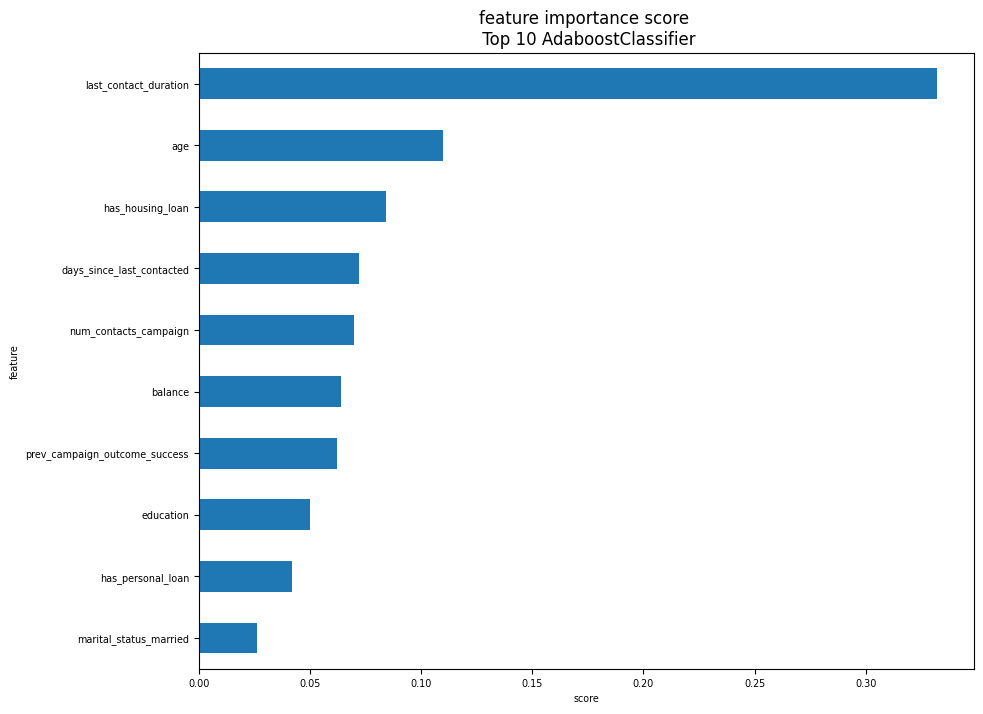

In [ ]:
%matplotlib inline
show_feature_importance(model_ab.best_estimator_)

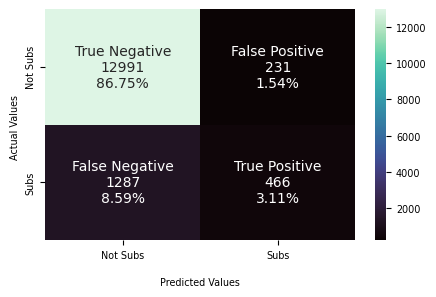

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


pred_ab = model_ab.predict(X_test)
c_matrix_plot(y_test, pred_ab)

## Simulasi Bisnis

In [ ]:
## Mengembalikan nilai yang sudah di normalisasi
X_test_invers = scaler.inverse_transform(X_test)

In [ ]:
## Membuat dataframe untuk data test
df_test = pd.DataFrame(X_test_invers, columns=[X.columns]).reset_index()
df_y = pd.DataFrame(y_test).reset_index()
df_test = pd.concat([df_test,df_y], axis = 1)

In [ ]:
## menghapus kolom index
df_test = df_test.drop(['index'], axis = 1)

In [ ]:
## memfilter data yang melakukan deposito berjangka
df_test_yes = df_test[df_test['has_subs_deposit'] == 1]

In [ ]:
## Membuat dataframe untuk data prediksi
df_pred = pd.DataFrame(X_test_invers, columns=[X.columns])
df_y_pred = pd.DataFrame(y_pred)
df_pred = pd.concat([df_pred,df_y_pred], axis = 1 )

In [ ]:
## Mengubah nama kolom agar mudah dibaca
new_kolom = ['age', 'age_category', 'job_type', 'job_type_admin', 'job_type_blue-collar',
    'job_type_entrepreneur', 'job_type_housemaid', 'job_type_management',
    'job_type_retired', 'job_type_self-employed', 'job_type_services',
    'job_type_student', 'job_type_technician', 'job_type_unemployed',
    'marital_status_divorced', 'marital_status_married', 'marital_status_single',
    'education', 'has_default', 'balance', 'has_housing_loan', 'has_personal_loan',
    'contact_type_cellular', 'contact_type_telephone', 'last_contact_duration',
    'num_contacts_campaign', 'days_since_last_contacted', 'num_contacts_before_campaign',
    'prev_campaign_outcome_failure', 'prev_campaign_outcome_not_contacted',
    'prev_campaign_outcome_other', 'prev_campaign_outcome_success',
    'prev_campaign_outcome_unknown','y_pred']
df_pred.columns = new_kolom

In [ ]:
## memfilter data yang melakukan deposito berjangka
df_pred_yes = df_pred[df_pred['y_pred'] == 1]

In [ ]:
print('Jumlah Nasabah Sebelum Model : ',  df_test_yes['has_subs_deposit'].value_counts())
print('Conversion Rate Sebelum Model : ',  (df_test_yes['has_subs_deposit'].count()/14975)*100)

Jumlah Nasabah Sebelum Model :  has_subs_deposit
1    1753
Name: count, dtype: int64
Conversion Rate Sebelum Model :  11.70617696160267


In [ ]:
print('Jumlah Nasabah Setelah model: ',  df_pred_yes['y_pred'].value_counts())
print('Conversion Rate Setelah Model : ',  (df_pred_yes['y_pred'].count()/14975)*100)

Jumlah Nasabah Setelah model:  y_pred
1    3534
Name: count, dtype: int64
Conversion Rate Setelah Model :  23.599332220367277
